In [1]:
import torch
from torch.utils.data import Dataset
from transformers import AutoTokenizer
import re
import torch.nn as nn
import numpy as np
import math
from torch.autograd import Variable
import torch.nn.functional as F
from transformers import AutoTokenizer
from tqdm import tqdm
import json
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import matplotlib.pyplot as plt
import sacrebleu

d:\final_exam\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. TranslateDataset
- Tạo lớp để tiền xử lý dữ liệu và transform dữ liệu

In [2]:
class TranslateDataset(Dataset):
    def __init__(self, source_tokenizer, target_tokenizer, source_data=None, target_data=None, source_max_seq_len=256, target_max_seq_len=256, phase="train"):
        self.source_data = source_data
        self.target_data = target_data
        self.source_tokenizer = source_tokenizer
        self.target_tokenizer = target_tokenizer
        self.source_max_seq_len = source_max_seq_len
        self.target_max_seq_len = target_max_seq_len
        self.phase = phase
    
    # Tiền xử lý câu đầu vào
    def preprocess_seq(self, seq):
        seq = re.sub(
        r"[\*\"“”\n\\…\+\-\/\=\(\)‘•:\[\]\|’\!;]", " ", str(seq))
        seq = re.sub(r"[ ]+", " ", seq)
        seq = re.sub(r"\!+", "!", seq)
        seq = re.sub(r"\,+", ",", seq)
        seq = re.sub(r"\?+", "?", seq)
        seq = seq.lower()
        return seq
    
    def __len__(self):
        return len(self.source_data)
    
    def __getitem__(self, index):
        source = self.source_tokenizer(
                text=self.preprocess_seq(self.source_data[index]),
                padding="max_length",
                max_length=self.source_max_seq_len,
                truncation=True,
                return_tensors="pt"
            )
        
        if self.phase == "train":
            target = self.target_tokenizer(
                text=self.preprocess_seq(self.target_data[index]),
                padding="max_length",
                max_length=self.target_max_seq_len,
                truncation=True,
                return_tensors="pt"
            )

            return {
                "source_seq": self.source_data[index],
                "source_ids": source["input_ids"][0],
                "target_seq": self.target_data[index],
                "target_ids": target["input_ids"][0],
                }
        else:
            return {
                "source_seq": self.source_data[index],
                "source_ids": source["input_ids"][0],
            }

### Config

In [3]:
configs = {
    "train_source_data":"./en_vi/data/train.en",
    "train_target_data":"./en_vi/data/train.vi",
    "valid_source_data":"./en_vi/data/tst2013.en",
    "valid_target_data":"./en_vi/data/tst2013.vi",
    "source_tokenizer":"bert-base-uncased",
    "target_tokenizer":"vinai/phobert-base",
    "source_max_seq_len":256,
    "target_max_seq_len":256,
    "batch_size":10,
    "device":"cuda:0" if torch.cuda.is_available() else "cpu",
    "embedding_dim": 512,
    "n_layers": 3,
    "n_heads": 8,
    "dropout": 0.1,
    "lr":0.2,
    "n_epochs":10,
    "beam_size":3,
    "model_path":"model_transformer_translate_en_vi.pt",
    "early_stopping":5
}

### Đọc dữ liệu từ file văn bản

In [4]:
def read_data(source_file, target_file):
    """
        Đọc dữ liệu từ 2 file source và target
        Trả về: 1D array chứa các câu với từng source và target
    """
    source_data = open(source_file, encoding='utf-8').read().strip().split("\n")
    target_data = open(target_file, encoding='utf-8').read().strip().split("\n")
    return source_data, target_data

## 2. Setup Transformer

### 2.1 Positional Encoding

In [5]:
class PositionalEncoder(nn.Module):
    def __init__(self, embedding_dim, max_seq_length=512, dropout=0.1):
        super(PositionalEncoder, self).__init__()
        
        self.embedding_dim = embedding_dim
        self.dropout = nn.Dropout(dropout)
        
        # Khởi tạo ma trận pe
        pe = torch.zeros(max_seq_length, embedding_dim)
        
        # Tính toán pe cho từng vị trí
        for pos in range(max_seq_length):
            for i in range(0, embedding_dim, 2):
                pe[pos, i] = math.sin(pos/(10000**(2*i/embedding_dim)))
                pe[pos, i+1] = math.cos(pos/(10000**((2*i+1)/embedding_dim)))
                
        # Thêm 1 chiều vào pe thành [1, max_seq_length, embedding_dim] đề phù hợp với quá trình training
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        # Chuẩn hóa vector embedding
        x = x*math.sqrt(self.embedding_dim)
        
        # Lấy ra độ dài của chuỗi
        seq_length = x.size(1)
        
        # Lấy ra phần tương ứng của pe với độ dài của chuỗi
        pe = Variable(self.pe[:, :seq_length], requires_grad=False).to(x.device)
        
        # Cộng word embedding với positional encoder
        x = x + pe
        x = self.dropout(x)
        return x

### 2.2 Self Attention

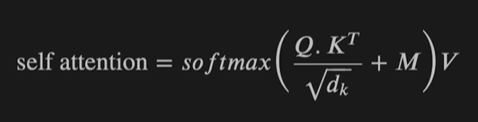

- Q stands for query vector
- K stands for key vector
- d_k stands for embedding_dim
- M stands for mask
- V stands for value vector

In [6]:
class SelfAttention(nn.Module):
    ''' Scaled Dot-Product Attention '''

    def __init__(self, dropout=0.1):
        super(SelfAttention, self).__init__()
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, mask=None):
        # shape query, key, value: (batch_size, n_head, seq_length, dim_per_head)
        key_dim = key.size(-1)
        attn = torch.matmul(query / np.sqrt(key_dim), key.transpose(2, 3)) # (batch_size, n_head, seq_length, seq_length)
        
        # mask của encoder thì biểu thị 1 cho các token của sequence, còn 0 biểu thị cho pad
        # mask của decoder có shape (seq_length, seq_length) là ma trận tam giác dưới, biểu thị trong lớp decoder với mỗi bước decode sẽ attention về chính từ đó và phía trước nó
        # không biết gì về tương lai là phía sau của nó
        if mask is not None:
            mask = mask.unsqueeze(1)
            attn = attn.masked_fill(mask == 0, -1e9)
        attn = self.dropout(torch.softmax(attn, dim=-1)) # attn: shape(batch_size, n_head, seq_length, seq_length)
        output = torch.matmul(attn, value) # output: shape(batch_size, n_head, seq_length, dim_per_head)

        return output

### 2.3 Multi-head Attention

In [7]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embedding_dim, num_heads, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        self.embedding_dim = embedding_dim
        self.self_attention = SelfAttention(dropout)
        self.num_heads = num_heads
        # Số chiều của mỗi head
        self.dim_per_head = embedding_dim // num_heads
        # Tạo các ma trận để chiếu biến đổi từ từng trong câu thành query, key, value
        self.query_projection = nn.Linear(embedding_dim, embedding_dim)
        self.key_projection = nn.Linear(embedding_dim, embedding_dim)
        self.value_projection = nn.Linear(embedding_dim, embedding_dim)
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(embedding_dim, embedding_dim)

    def forward(self, query, key, value, mask=None):
        # query, key, value: (batch_size, seq_length, embedding_dim)
        
        # Apply the linear projections
        batch_size = query.size(0)
        query = self.query_projection(query)
        key = self.key_projection(key)
        value = self.value_projection(value)
        
        # Reshape the input -> (batch_size, seq_length, n_head, dim_per_head)
        # Transpose: (batch_size, n_head, seq_length, dim_per_head)
        query = query.view(batch_size, -1, self.num_heads, self.dim_per_head).transpose(1, 2)
        key = key.view(batch_size, -1, self.num_heads, self.dim_per_head).transpose(1, 2)
        value = value.view(batch_size, -1, self.num_heads, self.dim_per_head).transpose(1, 2)
        
        # Tính toán ma trận attention
        scores = self.self_attention(query, key, value, mask)
        
        # Reshape ma trận attention về lại chiều của input
        output = scores.transpose(1, 2).contiguous().view(batch_size, -1, self.embedding_dim)
        
        # Apply the linear projection
        output = self.out(output)
        return output

### 2.4 Norm

In [8]:
class Norm(nn.Module):
    def __init__(self, embedding_dim):
        super(Norm, self).__init__()
        self.norm = nn.LayerNorm(embedding_dim)

    def forward(self, x):
        return self.norm(x)

### 2.5 Encoder Layer

In [9]:
class EncoderLayer(nn.Module):
    def __init__(self, embedding_dim, num_heads, ff_dim=2048, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.self_attention = MultiHeadAttention(embedding_dim, num_heads, dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(embedding_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embedding_dim)
        )
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.norm1 = Norm(embedding_dim)
        self.norm2 = Norm(embedding_dim)

    def forward(self, x, mask=None):
        x2 = self.self_attention(x, x, x, mask)
        x = x + self.dropout1(x2)
        x2 = self.feed_forward(x)
        x = x + self.dropout2(x2)
        x = self.norm2(x)
        
        return x

### 2.6 Decoder Layer

In [10]:
class DecoderLayer(nn.Module):
    def __init__(self, embedding_dim, num_heads, ff_dim=2048, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.self_attention = MultiHeadAttention(embedding_dim, num_heads, dropout)
        self.encoder_attention = MultiHeadAttention(embedding_dim, num_heads, dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(embedding_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embedding_dim)
        )
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)
        self.norm1 = Norm(embedding_dim)
        self.norm2 = Norm(embedding_dim)
        self.norm3 = Norm(embedding_dim)

    def forward(self, x, memory, source_mask, target_mask):
        x2 = self.self_attention(x, x, x, target_mask)
        x = x + self.dropout1(x2)
        x = self.norm1(x)
        
        x2 = self.encoder_attention(x, memory, memory, source_mask)
        x = x + self.dropout2(x2)
        x = self.norm2(x)
        
        x2 = self.feed_forward(x)
        x = x + self.dropout3(x2)
        x = self.norm3(x)
        
        return x

### 2.7 Encoder Transformer

In [11]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, max_seq_len, num_heads, num_layers, dropout=0.1):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.embedding_dim = embedding_dim
        self.layers = nn.ModuleList([EncoderLayer(embedding_dim, num_heads, 2048, dropout) for _ in range(num_layers)])
        self.norm = Norm(embedding_dim)
        self.position_embedding = PositionalEncoder(embedding_dim, max_seq_len, dropout)
    
    def forward(self, source, source_mask):
        # Embedding source + pe
        x = self.embedding(source)
        x = self.position_embedding(x)
        
        # Truyền qua từng encoder layer
        for layer in self.layers:
            x = layer(x, source_mask)
            
        # Norm
        x = self.norm(x)
        
        return x

### 2.8 Transformer Decoder

In [12]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, max_seq_len,num_heads, num_layers, dropout=0.1):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.embedding_dim = embedding_dim
        self.layers = nn.ModuleList([DecoderLayer(embedding_dim, num_heads, 2048, dropout) for _ in range(num_layers)])
        self.norm = Norm(embedding_dim)
        self.position_embedding = PositionalEncoder(embedding_dim, max_seq_len, dropout)
    
    def forward(self, target, memory, source_mask, target_mask):
        """
            memory: vector ngữ cảnh khi đã được đưa qua encoder
        """
        
        # Embedding target + pe
        x = self.embedding(target)
        x = self.position_embedding(x)
        
        # Truyền qua từng decoder layer
        for layer in self.layers:
            x = layer(x, memory, source_mask, target_mask)
            
        # Norm
        x = self.norm(x)
        
        return x

### 2.9 Transformer

In [13]:
class Transformer(nn.Module):
    def __init__(self, source_vocab_size, target_vocab_size, source_max_seq_len, target_max_seq_len, embedding_dim, num_heads, num_layers, dropout=0.1):
        super(Transformer, self).__init__()
        self.source_vocab_size = source_vocab_size
        self.target_vocab_size = target_vocab_size
        self.source_max_seq_len = source_max_seq_len
        self.target_max_seq_len = target_max_seq_len
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.dropout = dropout
    
        self.encoder = Encoder(source_vocab_size, embedding_dim, source_max_seq_len, num_heads, num_layers, dropout)
        self.decoder = Decoder(target_vocab_size, embedding_dim, target_max_seq_len, num_heads, num_layers, dropout)
        self.final_linear = nn.Linear(embedding_dim, target_vocab_size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, source, target, source_mask, target_mask):
        # Đưa source thông qua encoder
        memory = self.encoder(source, source_mask)
        
        # Đưa target thông qua decoder
        output = self.decoder(target, memory, source_mask, target_mask)
        
        # Chiếu 1 lớp tuyến tính để lấy đầu ra là vector có target_vocab_size chiều
        output = self.dropout(output)
        output = self.final_linear(output)
        
        return output
    
    # Tạo mask source
    def make_source_mask(self, source_ids, source_pad_id):
        return (source_ids != source_pad_id).unsqueeze(-2)

    # Tạo mask cho target
    def make_target_mask(self, target_ids):
        batch_size, len_target = target_ids.size()
        subsequent_mask = (1 - torch.triu(torch.ones((1, len_target, len_target), device=target_ids.device), diagonal=1)).bool()
        return subsequent_mask

## 3. Train model

### 3.1 Train epoch

In [14]:
def train_epoch(model, train_loader, optim, epoch, n_epochs, source_pad_id, target_pad_id, device):
    model.train()
    
    total_loss = []
    
    bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Training epoch {epoch+1}/{n_epochs}")
    
    for i, batch in bar:
        # Lấy từng batch dữ liệu
        source, target = batch["source_ids"].to(device), batch["target_ids"].to(device)
        
        # Input đầu vào gồm 255 token loại bỏ token ở cuối vì ở quá trình dự đoán mô hình sẽ dự đoán ra các token tiếp theo của từng token input
        target_input = target[:, :-1]
        
        # Tạo mask cho target và source
        source_mask, target_mask = model.make_source_mask(source, source_pad_id), model.make_target_mask(target_input)
        
        # Dự đoán
        preds = model(source, target_input, source_mask, target_mask)
        
        # reset gradient
        optim.zero_grad()
        
        # Output dự đoán được gồm 255 token
        gold = target[:, 1:].contiguous().view(-1)
        
        # compute loss
        loss = F.cross_entropy(preds.view(-1, preds.size(-1)), gold, ignore_index=target_pad_id)
        
        # backward loss để cập nhật các tham số của mô hình
        loss.backward()
        # optim.step()
        
        optim.step_and_update_lr()
        
        # Lưu lại loss của từng lần cập nhật
        total_loss.append(loss.item())
        bar.set_postfix(loss=total_loss[-1])
    
    # Average loss của epoch
    train_loss = sum(total_loss) / len(total_loss)
    
    return train_loss, total_loss

### 3.2 Validate epoch

In [15]:
def validate_epoch(model, valid_loader, epoch, n_epochs, source_pad_id, target_pad_id, device):
    model.eval()
    
    total_loss = []
    
    bar = tqdm(enumerate(valid_loader), total=len(valid_loader), desc=f"Validating epoch {epoch+1}/{n_epochs}")
    
    for i, batch in bar:
        source, target = batch["source_ids"].to(device), batch["target_ids"].to(device)
        target_input = target[:, :-1]
        source_mask, target_mask = model.make_source_mask(source, source_pad_id), model.make_target_mask(target_input)
        preds = model(source, target_input, source_mask, target_mask)
        gold = target[:, 1:].contiguous().view(-1)
        loss = F.cross_entropy(preds.view(-1, preds.size(-1)), gold, ignore_index=target_pad_id)
        total_loss.append(loss.item())
        bar.set_postfix(loss=total_loss[-1])

    valid_loss = sum(total_loss) / len(total_loss)
    return valid_loss, total_loss

### 3.3 Custom learning rate

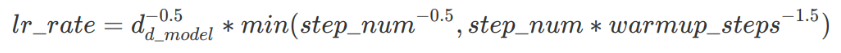

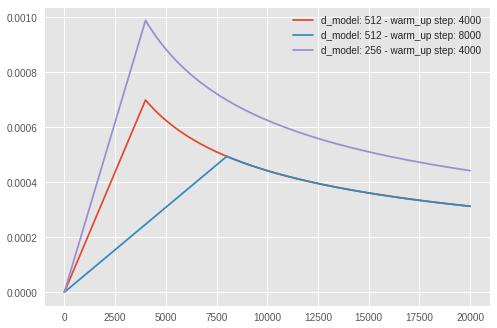

In [16]:
class ScheduledOptim():
    '''A simple wrapper class for learning rate scheduling'''

    def __init__(self, optimizer, init_lr, d_model, n_warmup_steps):
        self._optimizer = optimizer
        self.init_lr = init_lr
        self.d_model = d_model
        self.n_warmup_steps = n_warmup_steps
        self.n_steps = 0

    def step_and_update_lr(self):
        "Step with the inner optimizer"
        self._update_learning_rate()
        self._optimizer.step()

    def zero_grad(self):
        self._optimizer.zero_grad()

    def _get_lr_scale(self):
        d_model = self.d_model
        n_steps, n_warmup_steps = self.n_steps, self.n_warmup_steps
        return (d_model ** -0.5) * min(n_steps ** (-0.5), n_steps * n_warmup_steps ** (-1.5))

    def state_dict(self):
        optimizer_state_dict = {
            'init_lr':self.init_lr,
            'd_model':self.d_model,
            'n_warmup_steps':self.n_warmup_steps,
            'n_steps':self.n_steps,
            '_optimizer':self._optimizer.state_dict(),
        }
        
        return optimizer_state_dict
    
    def load_state_dict(self, state_dict):
        self.init_lr = state_dict['init_lr']
        self.d_model = state_dict['d_model']
        self.n_warmup_steps = state_dict['n_warmup_steps']
        self.n_steps = state_dict['n_steps']
        self._optimizer.load_state_dict(state_dict['_optimizer'])
        
    def _update_learning_rate(self):
        ''' Learning rate scheduling per step '''

        self.n_steps += 1
        lr = self.init_lr * self._get_lr_scale()

        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr

### 3.4 Training model

In [21]:
def train(model, train_loader, valid_loader, optim, n_epochs, source_pad_id, target_pad_id, device, model_path, early_stopping):
    log_dir = "./logs"
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)

    best_val_loss = np.Inf
    
    # determine the best epoch score
    best_epoch = 1
    
    # determine remain epoch to early stop training
    count_early_stop = 0
    
    # monitor model training process
    log = {"train_loss": [], "valid_loss": [], "train_batch_loss": [], "valid_batch_loss": []}
    
    for epoch in range(n_epochs):
        # train
        train_loss, train_losses = train_epoch(
            model=model,
            train_loader=train_loader,
            optim=optim,
            epoch=epoch,
            n_epochs=n_epochs,
            source_pad_id=source_pad_id, # determine id of source padding token
            target_pad_id=target_pad_id, # determine id of target padding token
            device=device
        )
        
        # loss
        valid_loss, valid_losses = validate_epoch(
            model=model,
            valid_loader=valid_loader,
            epoch=epoch,
            n_epochs=n_epochs,
            source_pad_id=source_pad_id,
            target_pad_id=target_pad_id,
            device=device
        )

        if valid_loss < best_val_loss:
            best_val_loss = valid_loss
            best_epoch = epoch + 1
            # save model
            torch.save(model.state_dict(), model_path)
            print("Detect effect and save the best model")
            count_early_stop = 0
        else:
            count_early_stop += 1
            if count_early_stop >= early_stopping:
                print("Early stopping")
                break

        torch.cuda.empty_cache()

        log["train_loss"].append(train_loss)
        log["valid_loss"].append(valid_loss)
        log["train_batch_loss"].extend(train_losses)
        log["valid_batch_loss"].extend(valid_losses)
        log["best_epoch"] = best_epoch
        log["best_val_loss"] = best_val_loss
        log["last_epoch"] = epoch + 1

        with open(os.path.join(log_dir, "log.json"), "w") as f:
            json.dump(log, f)

        print(f"Train loss {train_loss:.4f}")
        print(f"Valid loss {valid_loss:.4f}")
        print(f"Best Valid loss {best_val_loss:.4f}")
        print(f"Best epoch {best_epoch}")
    
    return log

- Đọc dữ liệu

In [16]:
train_src_data, train_trg_data = read_data(configs["train_source_data"], configs["train_target_data"])
valid_src_data, valid_trg_data = read_data(configs["valid_source_data"], configs["valid_target_data"])

In [17]:
# Sử dụng pho-bert-base và bert-base-uncased để tách từ biểu diễn từ thành index trong từ điển
source_tokenizer = AutoTokenizer.from_pretrained(configs["source_tokenizer"])
target_tokenizer = AutoTokenizer.from_pretrained(configs["target_tokenizer"])

d:\final_exam\venv\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\MSI\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
d:\final_exam\venv\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlink

- Khởi tạo mô hình

In [16]:
model = Transformer(
    source_vocab_size=source_tokenizer.vocab_size,
    target_vocab_size=target_tokenizer.vocab_size,
    embedding_dim=configs["embedding_dim"], # embedding_dim = 512
    source_max_seq_len=configs["source_max_seq_len"], # source_max_seq_len = 256
    target_max_seq_len=configs["target_max_seq_len"], # target_max_seq_len = 256
    num_layers=configs["n_layers"], # n_layers = 3
    num_heads=configs["n_heads"], # n_heads = 8
    dropout=configs["dropout"] # dropout = 0.1
)

- optimizer

In [27]:
optimizer = ScheduledOptim(torch.optim.Adam(model.parameters(), betas=(0.9, 0.98), eps=1e-09), configs['lr'], configs['embedding_dim'], 4000)

- đọc dữ liệu

In [49]:
train_dataset = TranslateDataset(
    source_tokenizer=source_tokenizer, 
    target_tokenizer=target_tokenizer, 
    source_data=train_src_data, 
    target_data=train_trg_data, 
    source_max_seq_len=configs["source_max_seq_len"],
    target_max_seq_len=configs["target_max_seq_len"],
)
valid_dataset = TranslateDataset(
    source_tokenizer=source_tokenizer, 
    target_tokenizer=target_tokenizer, 
    source_data=valid_src_data, 
    target_data=valid_trg_data, 
    source_max_seq_len=configs["source_max_seq_len"],
    target_max_seq_len=configs["target_max_seq_len"],
)

- Khởi tạo dataLoader cho training

In [53]:
device = torch.device(configs["device"])
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=configs["batch_size"],
    shuffle=True
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=configs["batch_size"],
    shuffle=False
)

#### Train model

In [ ]:
model.to(configs["device"])
log = train(model=model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    optim=optimizer,
    n_epochs=configs["n_epochs"],
    source_pad_id=source_tokenizer.pad_token_id,
    target_pad_id=target_tokenizer.pad_token_id,
    device=device,
    model_path=configs["model_path"],
    early_stopping=configs["early_stopping"]
)

#     plot_loss(log_path="./logs/log.json", log_dir="./logs")

In [30]:
def plot_loss(log_path, log_dir):
    log = json.load(open(log_path, "r"))

    plt.figure()
    plt.plot(log["train_loss"], label="train loss")
    plt.plot(log["valid_loss"], label="valid loss")
    plt.title("Loss/epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(os.path.join(log_dir, "loss_epoch.png"))

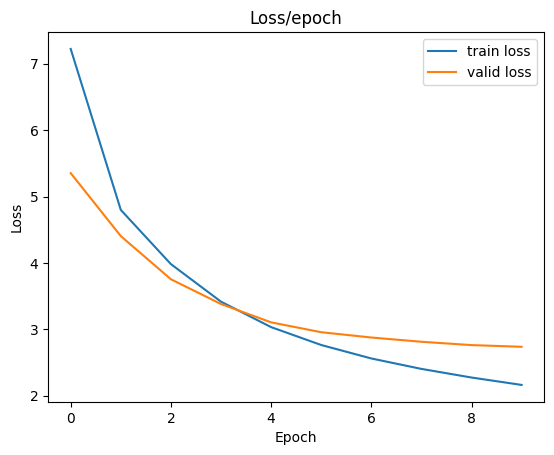

In [31]:
plot_loss('./log_final.json', './log')

### 3.5 Inference

- Load model and tokenizer

In [17]:
def load_model_tokenizer(configs):
    """
        This function will load model and tokenizer from pretrained model and tokenizer
    """
    device = torch.device(configs["device"])
    source_tokenizer = AutoTokenizer.from_pretrained(configs["source_tokenizer"])
    target_tokenizer = AutoTokenizer.from_pretrained(configs["target_tokenizer"])  

    # Load model Transformer
    model = Transformer(
        source_vocab_size=source_tokenizer.vocab_size,
        target_vocab_size=target_tokenizer.vocab_size,
        embedding_dim=configs["embedding_dim"],
        source_max_seq_len=configs["source_max_seq_len"],
        target_max_seq_len=configs["target_max_seq_len"],
        num_layers=configs["n_layers"],
        num_heads=configs["n_heads"],
        dropout=configs["dropout"]
    )
    model.load_state_dict(torch.load(configs["model_path"], map_location=torch.device('cpu')))
    model.eval()
    model.to(device)
    print(f"Done load model on the {device} device")  
    return model, source_tokenizer, target_tokenizer


- Translate sentence to target language

In [18]:
def translate(model, sentence, source_tokenizer, target_tokenizer, source_max_seq_len=256, 
    target_max_seq_len=256, beam_size=3, device=torch.device("cpu")):
    """
        Dịch ra câu đích từ câu đầu vào bằng beam search
    """
    # Lấy vector input_idx của vector source
    source_tokens = source_tokenizer.encode(sentence)[:source_max_seq_len]
    source_tensor = torch.tensor(source_tokens).unsqueeze(0).to(device)
    
    # Tạo source mask
    source_mask = model.make_source_mask(source_tensor, source_tokenizer.pad_token_id).to(device)
    
    # Lấy context vector từ encoder
    encoder_output = model.encoder.forward(source_tensor, source_mask)
    
    # Khởi tạo beams với token đầu tiên biểu thị bắt đầu của câu
    beams = [([target_tokenizer.bos_token_id], 0)]
    completed = []
    
    # Decode
    for _ in range(target_max_seq_len):
        new_beams = []
        for beam in beams:
            # Tạo target token
            input_token = torch.tensor([beam[0]]).to(device)
            
            # Tạo target mask
            target_mask = model.make_target_mask(input_token).to(device)
            
            # Decoder forward
            pred = model.decoder.forward(input_token, encoder_output, source_mask, target_mask)
            
            # forward qua tầng linear cuối cùng để lấy ra phân phối xác suất của các từ trong vocab
            pred = F.softmax(model.final_linear(pred), dim=-1)
            
            # Lấy giá trị cuối cuối là giá trị của token decode hiện tại
            pred = pred[:, -1, :].view(-1)
            
            # Lấy ra k token có xác suất lớn nhất
            top_k_scores, top_k_tokens = pred.topk(beam_size)
            
            # Cập nhật lại bim
            for i in range(beam_size):
                new_beams.append((beam[0] + [top_k_tokens[i].item()], beam[1] + top_k_scores[i].item()))
        
        import copy
        beams = copy.deepcopy(new_beams)
        # Sắp xếp beams theo điểm số của tổng xác suất các token của từng beam và lấy beam_size beam có điểm cao nhất
        beams = sorted(beams, key=lambda x: x[1], reverse=True)[:beam_size]
        
        # Nếu beam nào có token cuối là token kết thúc của câu thì loại bỏ ra khỏi beams và đưa vào completed - biểu thị beam đã được hoàn thành
        for beam in beams:
            if beam[0][-1] == target_tokenizer.eos_token_id:
                completed.append(beam)
                beams.remove(beam)
                beam_size -= 1

        # Dừng lại khi tất cả các khả năng đã hoàn thành
        if beam_size == 0:
            break

        
    # Sắp xếp các beam đã chứa toàn bộ câu theo điểm số xác suất của toàn bộ token trong beam
    completed.sort(key=lambda x: x[1], reverse=True)
    
    # Lấy ra beam có điểm số cao nhất
    target_tokens = completed[0][0]
    
    # Decode token của beam thành câu dịch
    target_sentence = target_tokenizer.decode(target_tokens, skip_special_tokens=True)
    
    return target_sentence

- Đánh giá mô hình trên tập test bằng BLEU score

In [19]:
def preprocess_seq(seq):
    seq = re.sub(
    r"[\*\"“”\n\\…\+\-\/\=\(\)‘•:\[\]\|’\!;]", " ", str(seq))
    seq = re.sub(r"[ ]+", " ", seq)
    seq = re.sub(r"\!+", "!", seq)
    seq = re.sub(r"\,+", ",", seq)
    seq = re.sub(r"\?+", "?", seq)
    seq = seq.lower()
    return seq

In [21]:
def calculate_bleu_score(model, source_tokenizer, target_tokenizer, configs):
    device = torch.device(configs["device"])
    
    valid_src_data, valid_trg_data = read_data(configs["valid_source_data"], configs["valid_target_data"])

    pred_sents = []
    for sentence in tqdm(valid_src_data):
        pred_trg = translate(model, sentence, source_tokenizer, target_tokenizer, configs["source_max_seq_len"], configs["target_max_seq_len"], configs["beam_size"], device)
        pred_sents.append(pred_trg)
    
    # write prediction to file
    with open("./predict_valid.txt", "w") as f:
        for sent in pred_sents:
            f.write(f"{sent}\n")

    hypotheses = [preprocess_seq(sent) for sent in pred_sents]
    references = [[sent] for sent in valid_trg_data]
    
    return sacrebleu.corpus_bleu(hypotheses, references)

In [20]:
device = torch.device(configs["device"])
model, source_tokenizer, target_tokenizer = load_model_tokenizer(configs)

Done load model on the cpu device


In [23]:
valid_trg_data = open('en_vi\\data\\tst2012.vi', encoding='utf-8').read().strip().split("\n")
references = [[sent] for sent in valid_trg_data]

In [24]:
hypotheses = open('predict_valid.txt', encoding='utf-8').read().strip().split("\n")
hypotheses = [preprocess_seq(sent) for sent in hypotheses]

In [25]:
blue_score = sacrebleu.corpus_bleu(hypotheses, references)
blue_score.score

37.72864447422507

In [23]:
sentence = "That report was written by 620 scientists from 40 countries ."
trans_sen = translate(
    model=model, 
    sentence=sentence, 
    source_tokenizer=source_tokenizer, 
    target_tokenizer=target_tokenizer, 
    source_max_seq_len=configs["source_max_seq_len"],
    target_max_seq_len=configs["target_max_seq_len"], 
    beam_size=configs["beam_size"], 
    device=device
)

In [24]:
trans_sen

'báo cáo này được viết bởi các nhà khoa học 13 quốc gia từ 40 quốc gia.'